In [88]:
from geomloss import SamplesLoss

# Intro 
- We'll look at geomloss and MMD loss function, InceptionV3 and how to train only the last layer 
- Second part will be training an MMD GAN, where we replace the InceptionV3 network and Renderer with a classical Discriminator - Generator Convolutional Architecture 
- We need to install geomloss from the latest master branch, I'm not confident that we'll get the best results if we just do pip install. 

## Pending Questions (in no particular order) 
- Does the original MetaSim train the last layer of the InceptionV3 network or does it keep the whole network frozen? during the GCN learning phase?  
- Can we learn with an MMD GAN to generate images that look like the target images, and have a sanity check that the MMD distance is indeed what we should be using (I'm not sure how valid this experiment is, since we're changing the architecture and essentially changing the problem. But it's good to test that we're doing the right thing in terms of workflow. 
- What resolution should we generate the synthetic images (target/source)? Original InceptionV3 expects 299x299 unless there's some re-writeup of the original one in MetaSim. Whatever resolution it is, it should be bigger than 299x299 and we can resize at loading time with torchvision.transforms
- What normalization should we apply at load time on the image? Since InceptionV3 is pre-trained on ImageNet, I believe it should be the right mean and std of ImageNet. Same for test time normalization. 
- What is a good size of the last layer? Since we have no classes, we can have 100 nodes or 1000. This will probably also be driven by OOM problems 
- Do we fix the OOM problems and how fast the MMD works if we move to SamplesLoss? Can we use batch_size = 100 and images of high enough resolution? I believe the OOM problems are related to how many images we're trying to fit into a batch, not with the actual computation. 

## InceptionV3
https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

## Using GeomLoss on sampled 10-D measures (distributions) 
 - you first have to "create" two distributions that you want to compare
 - I will use multivariate gaussians, instead of 1-D gaussians, since this is what we have if we move to images. 
 - for example, I have created two gaussians: 
     - they can be fully specified by their mean and variance 
     - they can also be specified by sampling from them, which is more in line with what we have. 
 - you can think of images as samples from some unknown data distribution 
 - this loss function then allows you to compare two distributions, by comparing their samples. The more samples you have, the more accurate the comparison. 
 - we'll use the "energy" kernel and the "gaussian" kernel or the "laplacian" kernels 
 - see this [nice post](https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution) about MMD and kernels 
 - a lot more theoretical is [page 97 of this PHD thesis (Author of geomloss)](https://www.jeanfeydy.com/geometric_data_analysis.pdf)
 
 *Ref from the library: https://www.kernel-operations.io/geomloss/api/pytorch-api.html 

In [89]:
from __future__ import print_function, division
%matplotlib inline
import os
import glob
import sys

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')
from pathlib import Path
sys.path.append("..")
import imageio
import matplotlib as mpl
import itertools

import pandas as pd
import numpy as np
#from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
import random
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Torch Dataset & Utils
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

# Optimizer, Functions, Distributions
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim
from torch import nn 
import torch.distributions as ds
import torchvision.utils as vutils
from torch.nn.utils import spectral_norm


#Models  - nldr is an Autoencoder library I wrote, probably not too useful. 
# import nldr
# from nldr.models.vanilla_vae import VAE, Encoder, Decoder, ConvEncoder, ConvDecoder
#from nldr.trainers.trainer import Trainer
#from nldr.tools.utils import Saving, SaveOutputs
#from nldr.datasets.mnist import MNIST_Loader
#from nldr.datasets.cifar import CIFAR10_Loader
#from nldr.datasets.visualize import Visualize
#Caltech256, Caltech256_Loader
#from torch.optim.lr_scheduler import LambdaLR, StepLR
#from torch.distributions import MultivariateNormal, LowRankMultivariateNormal


import geomloss
from geomloss import SamplesLoss
# SRW imports from nldr
# from nldr.datasets.synthetic import GaussianDataset

# Useful
get_types = lambda x :[(a, getattr(x, a)) for a in dir(x) if not callable(getattr(x, a)) and a[0] != '_']

# Change this to run locally 
parent_dir = "/home/federicoarenasl/Documents/Federico/UoE/MSC_AI/Thesis_project/implementation/meta-sim/custom-sim/data/geomloss/high_res/unity"
source_images = os.path.join(parent_dir, "prior/25")
target_images = os.path.join(parent_dir, "target")

In [90]:
numpy = lambda x : x.detach().cpu().numpy()
transpose = lambda x: np.transpose(numpy(x), (1, 2, 0))
positive = lambda x: [np.abs(a) for a in x]
gpu = torch.cuda.is_available()
device = None
if gpu:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')      

In [91]:
# Numpy 
seed = 2031
random.seed(seed)
np.random.seed(seed)

# Torch Seed 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [92]:
d = 10 # dimension of gaussians 
# this is the "size" of the vector or in our case, the shape of the image, seen as a 1D vector
n = 500 # how many samples from the distributions do you want 
# in our case, this would be number of images 

# Ignore k for now 
k = 5 

# Uniform weights for all samples, i.e. your distribution could allow for more "weight" for certain samples. 
a = (1./n) * np.ones(n)
b = (1./n) * np.ones(n)

# Wishart random covariances 
co1 = torch.randn(d,k) 
cov1 = torch.matmul(co1, co1.T)

co2  = torch.randn(d,k)
cov2  = torch.matmul(co2 , co2.T)

mu = np.random.multivariate_normal(np.zeros(d), cov1.numpy(), size = n)
nu = np.random.multivariate_normal(np.zeros(d), cov2.numpy(), size = n)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: covariance is not positive-semidefinite.


In [93]:
# As you can see, we've generated two distributions, both with 500 samples and of dimension 10. 
# You can think of this as an image reshaped to be of size 10 and there's 500 of them. 
print(mu.shape, nu.shape)

(500, 10) (500, 10)


/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


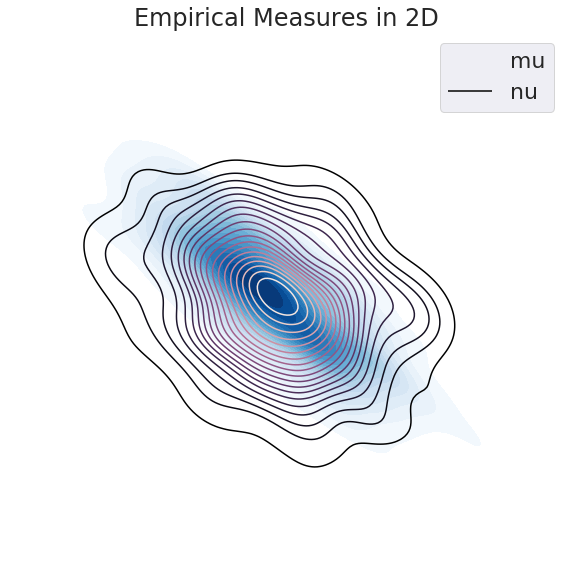

In [94]:
# There's 20 dimensions, plot using KDE plot ONLY the first two of the empirical measures show 
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(mu[:, 0], mu[:,1], cmap="Blues", n_levels=20, shade=True, label = "mu")
sns.kdeplot(nu[:, 0], nu[:,1], cmap=cmap, n_levels=20, shade= False, label = "nu")
xmin, xmax, ymin, ymax = plt.axis()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
#plt.xlim([-lim, lim])
#plt.ylim([-lim, lim])
plt.axis('off')
plt.title("Empirical Measures in 2D");
plt.legend();

In [95]:
print(os.getcwd())

/home/federicoarenasl/Documents/Federico/UoE/MSC_AI/Thesis_project/implementation/meta-sim/custom-sim/analysis_notebooks


In [96]:
# GeomLoss 
# loss1 = SamplesLoss(loss="sinkhorn", p=1, blur=0.001, scaling=0.95, debias=True)
loss_mmd_energy = SamplesLoss(loss='energy')
loss_mmd_gaussian = SamplesLoss(loss="gaussian", blur=0.001)


print("MMD Energy between sampled measures: ", 
      loss_mmd_energy(torch.tensor(mu),torch.tensor(nu)))

print("MMD Gaussian with small variance: ",
      loss_mmd_gaussian(torch.tensor(mu),torch.tensor(nu)))

MMD Energy between sampled measures:  tensor(0.2490, dtype=torch.float64)
MMD Gaussian with small variance:  tensor(0.0020, dtype=torch.float64)


*By definition MMD between the equal distributions, is zero :)* 

In [97]:
print("MMD Energy between same measures is: ", 
     loss_mmd_gaussian(torch.tensor(nu),torch.tensor(nu)))

MMD Energy between same measures is:  tensor(0., dtype=torch.float64)


## MMD between Image samples 
   - Step 1: Create a torch Dataset and DataLoaders for our datasets, so we can sample 
   - Step 2: Use an "encoder" to push images from 32x32 to size 10 and compute MMD in the "feature" space 
   - Step 4: Train a GAN MMD to "generate" samples that look like the target samples. 
   - Step 5: Replace GAN MMD with a renderer and use only the "encoder" part 

In [98]:
#from torchvision.io import read_image
from PIL import Image, ImageFile

class ShoeDataset(Dataset):
    def __init__(self, root: str, transforms=None):

        super(ShoeDataset, self).__init__()
        self.root = Path(root)
        self.transforms = transforms
        
        self.imgs_path = sorted([file for file in self.root.iterdir()]) 
        

    def __getitem__(self, idx: int):

        # Load Image
        img_path = self.root / self.imgs_path[idx]
        
        #read_image(str(img_path))
        orig_img = Image.open(str(img_path)).convert("RGB")
        #image_np = np.asarray(orig_img).astype(np.float32)
        
        if self.transforms:
            #return self.augmentations(image=image_np)['image'], label
            return self.transforms(orig_img)
        else:
            return image

    def __len__(self) -> int:
        return len(self.imgs_path)

    def collate_fn(self, batch):
        return tuple(zip(*batch))

IMAGE_SIZE = 224
# We should generate images that are big, but resize them to Inception scale before using the model 
# We don't want to upscale the images 
# **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
# N x 3 x 299 x 299, so ensure your images are sized accordingly.

IMAGE_SIZE_INCEPTION = 299 
shoe_transformer = torchvision.transforms.Compose([
                               torchvision.transforms.Resize(IMAGE_SIZE_INCEPTION),
                               #torchvision.transforms.CenterCrop(IMAGE_SIZE),
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])
default_transformer = torchvision.transforms.ToTensor()

In [99]:
source_dataset = ShoeDataset(root = source_images, transforms = shoe_transformer)
target_dataset = ShoeDataset(root = target_images, transforms = shoe_transformer)

# Assign batch size the whole dataset 
bs_source = len(source_dataset)
bs_target = len(target_dataset)

source_loader = DataLoader(source_dataset, batch_size = bs_source, shuffle = True, drop_last=False)
target_loader = DataLoader(target_dataset, batch_size = bs_target, shuffle = True, drop_last=False)

In [100]:
X1 = iter(source_loader).next()
X2 = iter(target_loader).next()

In [62]:
print(X1.shape, X2.shape)

torch.Size([100, 3, 299, 299]) torch.Size([100, 3, 299, 299])


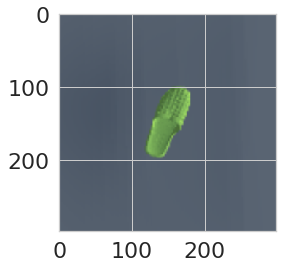

In [63]:
plt.imshow(transpose(X1[1]));

In [64]:
print(X1.view(-1,3,299*299).shape)

torch.Size([100, 3, 89401])


In [65]:
# As you can see, it doesn't make much sense to compare MMD between images, because they have 3 channels. 
# So we push them through the inception network first
print("MMD Energy between images is: ", 
     loss_mmd_gaussian(X1.view(-1,3,299*299), X2.view(-1,3,299*299)))

MMD Energy between images is:  tensor([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf])


In [66]:
# If we set transform_input to True, it will normalize the images according to the ImageNet training  
# See https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Inception V3 always needs 299 as input size, so when you go from 32x32 to 299, you do upsampling which is no no. 
# https://pytorch.org/vision/stable/_modules/torchvision/models/inception.html
model_inception = models.inception_v3(pretrained=True, transform_input=True)

In [67]:
# Auxiliary net 
model_inception.AuxLogits.fc

Linear(in_features=768, out_features=1000, bias=True)

In [68]:
# Primary net
model_inception.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [69]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [70]:
# input_size = 299
# Set output layer to 100 because why not 
out_features = 100 

# Handle the auxilary net
model_inception.AuxLogits.fc = nn.Linear(768, out_features)

# Handle the primary net
model_inception.fc = nn.Linear(2048,out_features)

# When feature_extract is True, you only train the very last layer! Super important and useful! 
set_parameter_requires_grad(model_inception, feature_extract=True)

In [71]:
model_inception.fc

Linear(in_features=2048, out_features=100, bias=True)

In [72]:
model_inception.AuxLogits.fc

Linear(in_features=768, out_features=100, bias=True)

In [73]:
X1.shape

torch.Size([100, 3, 299, 299])

In [74]:
outputs_X1, aux_outputs_X1 = model_inception(X1) # shape batch_size = 100, outdim = 100 
out_features_X2, aux_outputs_X2 = model_inception(X2) # shape batch_size = 100, out_dim = 100

In [75]:
aux_outputs_X1.shape

torch.Size([100, 100])

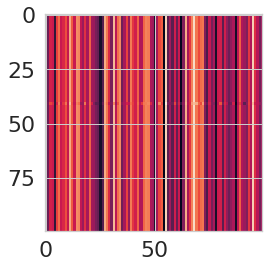

In [77]:
plt.imshow(aux_outputs_X1)

In [ ]:
outputs_X1.shape

In [ ]:
out_features_X2.shape

In [ ]:
out_features_X2

In [ ]:
# Now that we have the features, we get an instant result for the MMD :) 
print("MMD Energy between feature space is: ", loss_mmd_gaussian(outputs_X1, out_features_X2))

In [ ]:
print("MMD Energy between feature space is: ", loss_mmd_energy(outputs_X1, out_features_X2))

**Important: During training, we have to create two losses for the InceptionV3, based on the two heads the network has. At test time we only use the main network head**

In [52]:
# Combine losses from outputs and auxiliary outputs
loss1 = loss_mmd_gaussian(outputs_X1, out_features_X2)
loss2 = loss_mmd_gaussian(aux_outputs_X1, aux_outputs_X2)
loss = loss1 + 0.4*loss2
print("Final loss is: ", loss)

Final loss is:  tensor(0.1829)


## Visualizing feature maps from Inception

In [78]:
print(model_inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## Accessing convolutional layers

In [83]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model_inception.children())

In [87]:
model_children

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 InceptionA(
   (branch1x1): BasicConv2d(
     (conv): Conv2d(192, 64, kernel_size=